# Mapping

This file produces a list of bridges with valid geographical coordinates for bridges in Anne Arundel County, Baltimore City, Baltimore County, Carroll County, Harford County and Howard County.

The file uses geographical information from the 2017 the Federal Highway Administration's National Bridge Inventory data, processed in `01_processing.ipynb`, as the starting point. The `LAT_016` and `LONG_017` fields in the data from FHA provide the latitude and longitude of bridges in degrees, minutes and seconds. This information is merged with data from the Bureau of Transportation Statistics, which has created its own [its own version](http://osav-usdot.opendata.arcgis.com/datasets/5ba496f7f5484a65bee680949147c762_0) of the National Bridge Inventory for a selection of bridges. The Bureau of Transportation Statistics provides coordinates in decimal degrees.

For bridges that do not have geographical information from the Bureau of Transporation Statistics, the coordinates provided in the National Bridge Inventory are converted from degrees, minutes and seconds into decimal degrees using [this formula](https://andrew.hedges.name/experiments/convert_lat_long/). 

The coordinates provided for each county's bridges are verified so that only bridges that are actually within the county's borders are included as having valid coordinates. For example, a bridge that is listed as being in "Baltimore City" but whose coordinates place it in "Howard County" would be considered as having invalid coordinates.

Additional geographical information is obtained and merged in from [BridgeReports.com](http://bridgereports.com/), a searchable version of the National Bridge Inventory.

### Import R data analysis packages and read in 2017 data

In [1]:
suppressMessages(library('feather'))
suppressMessages(library('rgeos'))
suppressMessages(library('sp'))
suppressMessages(library('rgdal'))
suppressMessages(library('tidyverse'))

In [2]:
data.2017.clean <- read_feather('output/data_2017_clean.feather')

### Read in Maryland's county shapefiles

Maryland's county shapefiles were obtained from Maryland's GIS Open Data Catalog, available [here](http://data.imap.maryland.gov/datasets/4c172f80b626490ea2cff7b699febedb_1).

In [3]:
counties <- readOGR("input/Maryland_Physical_Boundaries__County_Boundaries_Generalized/Maryland_Physical_Boundaries__County_Boundaries_Generalized.shp")
counties2 <- counties %>%
  fortify(region = "county") %>%
  as_tibble() %>%
  left_join(counties@data, by = c("id" = "county"))

OGR data source with driver: ESRI Shapefile 
Source: "/Users/czhang/Documents/bridges/Sharing/input/Maryland_Physical_Boundaries__County_Boundaries_Generalized/Maryland_Physical_Boundaries__County_Boundaries_Generalized.shp", layer: "Maryland_Physical_Boundaries__County_Boundaries_Generalized"
with 24 features
It has 7 fields
Integer64 fields read as strings:  OBJECTID district county_fip countynum 


Warning message:
“Column `id`/`county` joining character vector and factor, coercing into character vector”

### Merge in coordinates from the Bureau of Transportation Statistics

The Bureau of Transportation Statistics file is too large to be included in this repository, but it can be downloaded on the "Geospatial at the Bureau of Transportation Statistics" [website](http://osav-usdot.opendata.arcgis.com/datasets/5ba496f7f5484a65bee680949147c762_0).  

In [4]:
bridges.bts <- suppressMessages(read_csv('input/National_Bridge_Inventory.csv', 
                                         guess_max = 600000))

In [5]:
data.2017.clean <- merge(data.2017.clean,
      bridges.bts %>% select(new_src_1_STRUCTURE_NUMBER_008, new_src_1_LATDD, new_src_1_LONGDD),
      by.x = 'STRUCTURE_NUMBER_008', by.y = 'new_src_1_STRUCTURE_NUMBER_008', all.x = T)

### For bridges that don't have Bureau of Transportation coordinates, convert National Bridge Inventory coordinates to decimal degrees

Some bridges are not included in the Bureau of Transportation statistics site but have coordinates data (in degrees, minutes, and seconds) in the National Bridge Inventory. For these, the coordinates are converted to decimal lat/long degrees.

In [6]:
data.2017.clean$latdegrees = as.numeric(substr(data.2017.clean$LAT_016, start = 1, stop = 2))
data.2017.clean$latminutes = as.numeric(substr(data.2017.clean$LAT_016, start = 3, stop = 4))
data.2017.clean$latseconds = as.numeric(paste0(substr(data.2017.clean$LAT_016, start = 5, stop = 6), ".", 
                                    substr(data.2017.clean$LAT_016, start = 7, stop = 8)))

data.2017.clean$longdegrees = as.numeric(substr(data.2017.clean$LONG_017, start = 1, stop = 3))
data.2017.clean$longminutes = as.numeric(substr(data.2017.clean$LONG_017, start = 4, stop = 5))
data.2017.clean$longseconds = as.numeric(paste0(substr(data.2017.clean$LONG_017, start = 6, stop = 7), ".", 
                                    substr(data.2017.clean$LONG_017, start = 8, stop = 9)))

data.2017.clean$lat_dd_calc <- data.2017.clean$latdegrees + (data.2017.clean$latminutes / 60 + (data.2017.clean$latseconds / 3600))
data.2017.clean$long_dd_calc <- -1 * (data.2017.clean$longdegrees + (data.2017.clean$longminutes / 60 + (data.2017.clean$longseconds / 3600)))

data.2017.clean$lat <- ifelse(is.na(data.2017.clean$new_src_1_LATDD) & 
                              data.2017.clean$LAT_016 != '00000000', 
                              data.2017.clean$lat_dd_calc, 
                              data.2017.clean$new_src_1_LATDD)

data.2017.clean$long <- ifelse(is.na(data.2017.clean$new_src_1_LONGDD) & 
                               data.2017.clean$LONG_017 != '000000000', 
                               data.2017.clean$long_dd_calc, 
                               data.2017.clean$new_src_1_LONGDD)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

### For each county, check if the provided coordinates are actually in the county

The bridges cannot simply be mapped as-is, since some of the purported geographical coordinates place the corresponding bridges in a different county or a different state entirely. For example, here are the bridges listed as being in Anne Arundel County.

In [7]:
options(repr.plot.width = 5, repr.plot.height = 4)

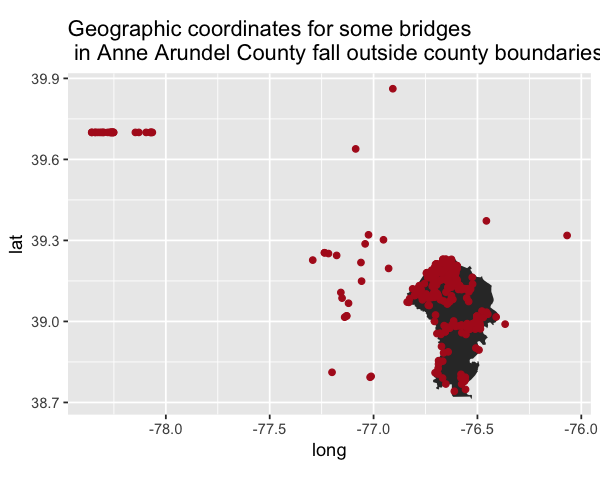

In [8]:
print(ggplot(counties2 %>% filter(id == 'Anne Arundel'), 
       aes(x = long, y = lat, group = group)) + geom_polygon() + 
  coord_fixed(1.3) + ggtitle("Geographic coordinates for some bridges\n in Anne Arundel County fall outside county boundaries") +
geom_point(data = data.2017.clean %>% filter(county == 'Anne Arundel County'), 
           aes(x = long, y = lat, group = county), color = '#B11B20'))

A function to determine whether or not the coordinates in `data.2017.clean` are valid (i.e., fall within each county's boundaries):

In [9]:
## This function will return a dataframe of bridges that have coordinates are not located inside their listed counties.

process <- function (county1, county2) {
    county.data <- data.2017.clean %>% mutate(county = tolower(county)) %>% filter(county == county1 &
                                      !is.na(long) & long >= -180) %>% select(lat, long, STRUCTURE_NUMBER_008, county) %>% 
    as.data.frame()
    coordinates(county.data) <- ~ long + lat
    county.shape <- counties[counties$county == county2, ]
    proj4string(county.data) <- proj4string(county.shape)
    not.in.county <- is.na(over(county.data, as(county.shape, "SpatialPolygons")))
    county.coords <- data.2017.clean %>% mutate(county = tolower(county)) %>% filter(county == county1
                                                                                     & !is.na(long) & long >= -180) %>% select( 
                                                                                         STRUCTURE_NUMBER_008, county, lat, long, 
           location, intersects, carries, yr_built, responsibility, owner, bridge_condition, avg_daily_traffic, total_improve_cost, inspection_mo, inspection_yr)
    not.in.county.bridges <- cbind(county.coords, not.in.county)
    return(not.in.county.bridges)
    }

In [10]:
annearundel.invalid_coordinates <- process('anne arundel county', 'Anne Arundel')
baltcity.invalid_coordinates <- process('baltimore city', 'Baltimore City')
baltco.invalid_coordinates <- process('baltimore county', 'Baltimore')
carroll.invalid_coordinates <- process('carroll county', 'Carroll')
harford.invalid_coordinates <- process('harford county', 'Harford')
howard.invalid_coordinates <- process('howard county', 'Howard')

bridges.combined <- rbind(baltcity.invalid_coordinates, 
                          baltco.invalid_coordinates, 
                          annearundel.invalid_coordinates, 
                          harford.invalid_coordinates, 
                          howard.invalid_coordinates, 
                          carroll.invalid_coordinates)

### Merge in coordinates from BridgeReports.com for bridges that have invalid coordinates

The file `bridgereports.csv.zip` must first be unzipped.

In [11]:
unzip("input/bridgereports.csv.zip", exdir = 'input/')

In [12]:
bridgereports <- suppressMessages(read_csv('input/bridgereports.csv'))

In [13]:
bridges.combined.counties <- merge(bridges.combined, bridgereports, 
                                   by.x = 'STRUCTURE_NUMBER_008', 
                                   by.y = 'id', all.x = T, 
                                   suffixes = c('_data', '_br'))

bridges.combined.counties <- bridges.combined.counties %>% 
                                    mutate(lat_new = ifelse(not.in.county == TRUE, lat_br, lat_data),
                                    long_new = ifelse(not.in.county == TRUE, long_br, long_data))

In [14]:
bridges.combined.counties$lat_new <- as.numeric(bridges.combined.counties$lat_new)
bridges.combined.counties$long_new <- as.numeric(bridges.combined.counties$long_new)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [15]:
### make sure coordinates are valid

process_br <- function (county1, county2) {
    county.data <- bridges.combined.counties %>% mutate(county = tolower(county)) %>% filter(!is.na(lat_new) & 
                                                                                             county == county1) %>% 
    select(lat_new, long_new, STRUCTURE_NUMBER_008, county) %>% 
    as.data.frame()
    coordinates(county.data) <- ~ long_new + lat_new
    county.shape <- counties[counties$county == county2, ]
    proj4string(county.data) <- proj4string(county.shape)
    not.in.county <- is.na(over(county.data, as(county.shape, "SpatialPolygons"))) 
    county.coords <- bridges.combined.counties %>% mutate(county = tolower(county)) %>% filter(!is.na(lat_new) & 
                                                                                             county == county1) %>% 
    select(lat = lat_new, long = long_new, STRUCTURE_NUMBER_008, county, 
           location, intersects, carries, yr_built, bridge_condition, avg_daily_traffic, total_improve_cost, inspection_mo, inspection_yr, owner, responsibility) %>%
    mutate(owner = str_to_title(owner), responsibility = str_to_title(responsibility))
    not.in.county.bridges <- cbind(county.coords, not.in.county)
    return(not.in.county.bridges)
    }

In [16]:
baltcity.bridges.geocoded <- process_br('baltimore city', 'Baltimore City')%>% filter(not.in.county == FALSE) %>% select(-not.in.county) %>% mutate(county = str_to_title(county)) 
baltco.bridges.geocoded <- process_br('baltimore county', 'Baltimore') %>% filter(not.in.county == FALSE) %>% select(-not.in.county) %>% mutate(county = str_to_title(county)) 
annearundel.bridges.geocoded <- process_br('anne arundel county', 'Anne Arundel') %>% filter(not.in.county == FALSE) %>% select(-not.in.county)%>% mutate(county = str_to_title(county)) 
harford.bridges.geocoded <- process_br('harford county', 'Harford') %>% filter(not.in.county == FALSE) %>% select(-not.in.county)%>% mutate(county = str_to_title(county)) 
howard.bridges.geocoded <- process_br('howard county', 'Howard') %>% filter(not.in.county == FALSE) %>% select(-not.in.county)%>% mutate(county = str_to_title(county))
carroll.bridges.geocoded <- process_br('carroll county', 'Carroll') %>% filter(not.in.county == FALSE) %>% select(-not.in.county)%>% mutate(county = str_to_title(county))

### Plot points to make sure bridges fall within their designated counties

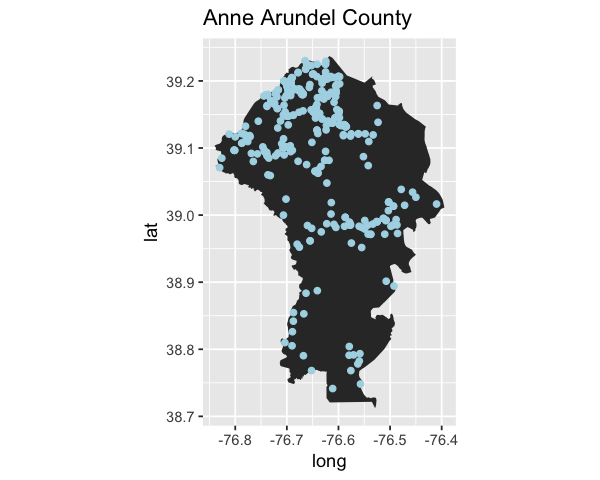

In [17]:
print(ggplot(counties2[counties2$id == 'Anne Arundel', ], 
       aes(x = long, y = lat, group = group)) + geom_polygon() + 
  coord_fixed(1.3) + ggtitle(annearundel.bridges.geocoded$county) +
geom_point(data = annearundel.bridges.geocoded, aes(x = long, y = lat, group = 1), color = 'lightblue'))

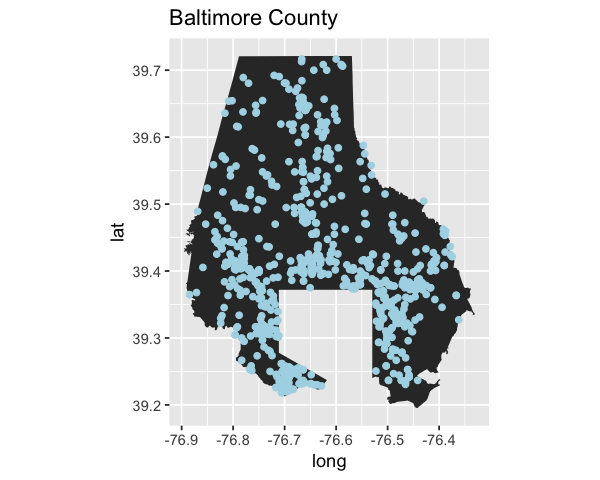

In [18]:
print(ggplot(counties2[counties2$id == 'Baltimore', ], 
       aes(x = long, y = lat, group = group)) + geom_polygon() + 
  coord_fixed(1.3) + ggtitle(baltco.bridges.geocoded$county) +
geom_point(data = baltco.bridges.geocoded, aes(x = long, y = lat, group = 1), color = 'lightblue'))

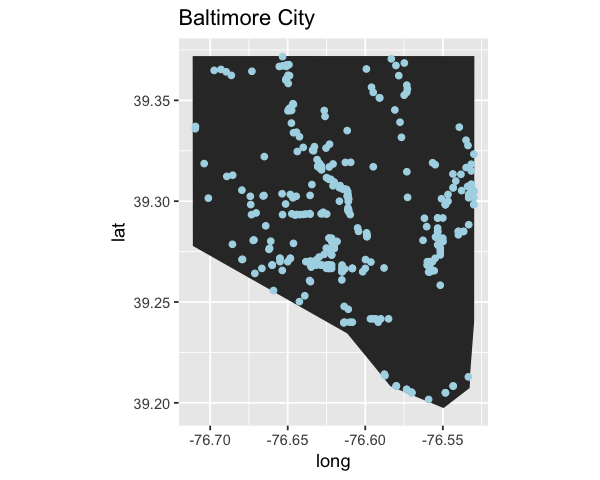

In [19]:
print(ggplot(counties2[counties2$id == 'Baltimore City', ], 
       aes(x = long, y = lat, group = group)) + geom_polygon() + 
  coord_fixed(1.3) + ggtitle(baltcity.bridges.geocoded$county) +
geom_point(data = baltcity.bridges.geocoded, aes(x = long, y = lat, group = 1), color = 'lightblue'))

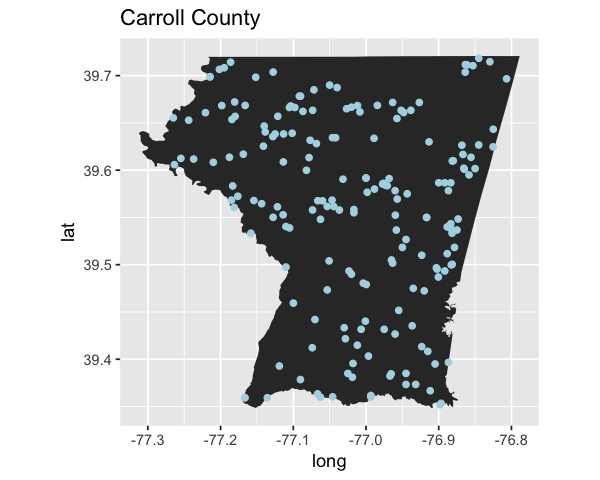

In [20]:
print(ggplot(counties2[counties2$id == 'Carroll', ], 
       aes(x = long, y = lat, group = group)) + geom_polygon() + 
  coord_fixed(1.3) + ggtitle(carroll.bridges.geocoded$county) +
geom_point(data = carroll.bridges.geocoded, aes(x = long, y = lat, group = 1), color = 'lightblue'))

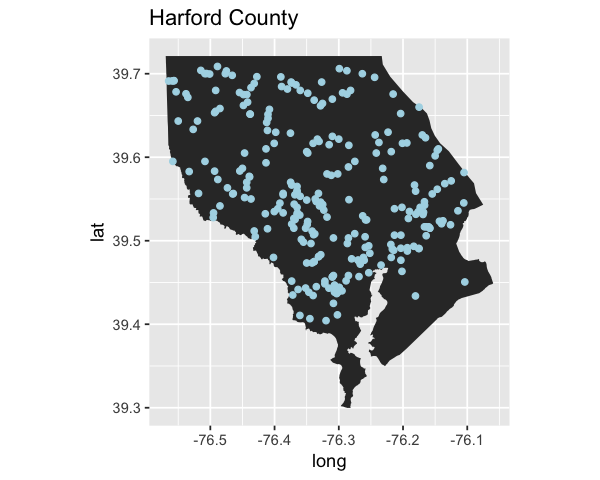

In [21]:
print(ggplot(counties2[counties2$id == 'Harford', ], 
       aes(x = long, y = lat, group = group)) + geom_polygon() + 
  coord_fixed(1.3) + ggtitle(harford.bridges.geocoded$county) +
geom_point(data = harford.bridges.geocoded, aes(x = long, y = lat, group = 1), color = 'lightblue'))

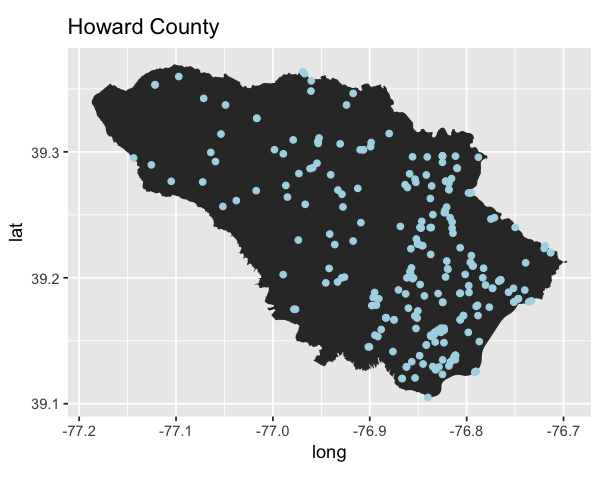

In [22]:
print(ggplot(counties2[counties2$id == 'Howard', ], 
       aes(x = long, y = lat, group = group)) + geom_polygon() + 
  coord_fixed(1.3) + ggtitle(howard.bridges.geocoded$county) +
geom_point(data = howard.bridges.geocoded, aes(x = long, y = lat, group = 1), color = 'lightblue'))

### Create dataframes for mapping

In [23]:
bridges.geocoded <- rbind(annearundel.bridges.geocoded,
                          baltcity.bridges.geocoded, 
                          baltco.bridges.geocoded,
                          carroll.bridges.geocoded,
                          harford.bridges.geocoded,
                          howard.bridges.geocoded)

In [24]:
### add in Harford Road Bridge coordinates via https://bridgehunter.com/md/baltimore-city/200000BC3212010/ 
### another bridge on the CECIL-HARFORD COUNTY LINE https://bridgereports.com/1244661
### plus more accurate coordinates for US 40 EDMONDSON AV and ANNAPOLIS ROAD/WATERVIEW AVE bridges
### plus Wicomico Street bridge (now demolished, but mapped & labeled with current status) http://bridgehunter.com/md/baltimore-city/200000BC8032010/

additional.bridges <- data.2017.clean %>% select(STRUCTURE_NUMBER_008, county, lat, long, 
           location, intersects, carries, yr_built, responsibility, owner, 
           bridge_condition, avg_daily_traffic, total_improve_cost, inspection_mo, inspection_yr) %>%
           filter(STRUCTURE_NUMBER_008 == '200000BC3212010' | 
                  STRUCTURE_NUMBER_008 == '300000H-Z040010' |
                  STRUCTURE_NUMBER_008 == '200000BC2202010' |
                  STRUCTURE_NUMBER_008 == '200000BC5407040' |
                  STRUCTURE_NUMBER_008 == '200000BC8032010') %>%
           mutate(lat = 1, long = 1) %>%
                  mutate(lat = ifelse(STRUCTURE_NUMBER_008 == '200000BC3212010',
                                                      39.33382, lat),
                                                long = ifelse(STRUCTURE_NUMBER_008 == '200000BC3212010',
                                                      -76.57653, long),
                                                lat = ifelse(STRUCTURE_NUMBER_008 == '300000H-Z040010',
                                                      39.56348, lat),
                                                long = ifelse(STRUCTURE_NUMBER_008 == '300000H-Z040010',
                                                      -76.08393, long), 
                                                lat = ifelse(STRUCTURE_NUMBER_008 == '200000BC2202010',
                                                      39.29421, lat),
                                                long = ifelse(STRUCTURE_NUMBER_008 == '200000BC2202010',
                                                      -76.670507, long),
                                                lat = ifelse(STRUCTURE_NUMBER_008 == '200000BC5407040',
                                                      39.2608816, lat),
                                                long = ifelse(STRUCTURE_NUMBER_008 == '200000BC5407040',
                                                      -76.6361141, long),
                                                lat = ifelse(STRUCTURE_NUMBER_008 == '200000BC8032010',
                                                      39.26785, lat),
                                                long = ifelse(STRUCTURE_NUMBER_008 == '200000BC8032010',
                                                      -76.64364, long))

In [25]:
bridges.geocoded.plus <- rbind(bridges.geocoded, 
                               additional.bridges)

bridges.geocoded.plus <- bridges.geocoded.plus %>% 
                         mutate(vehicles = paste(avg_daily_traffic, 
                                                'vehicles')) %>%
                         rename(total_improve_cost_thousands = total_improve_cost)

In [26]:
# fix deer creek road coordinates
bridges.geocoded.plus %>% filter(STRUCTURE_NUMBER_008 == '10202') # first one is the correct one

lat,long,STRUCTURE_NUMBER_008,county,location,intersects,carries,yr_built,bridge_condition,avg_daily_traffic,total_improve_cost_thousands,inspection_mo,inspection_yr,owner,responsibility,vehicles
39.61712,-76.19404,10202,Harford County,ABERDEEN PROVING GROUND,DEER CREEK,ACCESS ROAD,1982,Poor,10,2,07,15,Army,Army,10 vehicles
39.51667,-76.16667,10202,Harford County,ABERDEEN PROVING GROUND,DEER CREEK,ACCESS ROAD,1982,Poor,10,2,07,15,Army,Army,10 vehicles


In [27]:
bridges.geocoded.plus <- bridges.geocoded.plus %>% 
            group_by(STRUCTURE_NUMBER_008) %>% mutate(n = row_number()) %>% filter(n == 1) %>% select(-n)

In [28]:
data.2007.clean <- read_feather('output/data_2007_clean.feather')

In [29]:
poor.2007 <- data.2007.clean %>% filter(bridge_condition == 'Poor')
poor.2017 <- data.2017.clean %>% filter(bridge_condition == 'Poor') 

persistently.poor <- merge(poor.2007, poor.2017, 
                               by = 'STRUCTURE_NUMBER_008', suffixes = c('_07', '_17')) %>% 
                           filter(county_17 == 'Anne Arundel County' | 
                             county_17 == 'Baltimore city' | 
                             county_17 == 'Baltimore County' |
                             county_17 == 'Carroll County' | 
                             county_17 == 'Harford County' |
                             county_17 == 'Howard County')

In [30]:
persistently.poor <- persistently.poor %>% 
            group_by(STRUCTURE_NUMBER_008) %>% mutate(n = row_number()) %>% filter(n == 1)%>% select(-n)

In [31]:
persistently.poor.geocoded <- persistently.poor %>% select(STRUCTURE_NUMBER_008, county = county_17, location = location_17, 
                                                           intersects = intersects_17, carries = carries_17, yr_built = yr_built_17,
                              bridge_condition = bridge_condition_17, avg_daily_traffic = avg_daily_traffic_17,
                                                           owner = owner_17, responsibility = responsibility_17) %>%
                              left_join(bridges.geocoded.plus %>% select(STRUCTURE_NUMBER_008, lat, long,
                                                                        total_improve_cost_thousands, vehicles), 
                                        by = 'STRUCTURE_NUMBER_008')

In [32]:
persistently.poor.geocoded <- persistently.poor.geocoded %>% mutate(owner = str_to_title(owner),
                                                  responsibility = str_to_title(responsibility))

In [33]:
persistently.poor.geocoded %>% filter(STRUCTURE_NUMBER_008 == '200000BC5407040')

STRUCTURE_NUMBER_008,county,location,intersects,carries,yr_built,bridge_condition,avg_daily_traffic,owner,responsibility,lat,long,total_improve_cost_thousands,vehicles
200000BC5407040,Baltimore city,WATERVIEW ANNAPO RD JCT,WATERVIEW AVENUE,ANNAPOLIS ROAD,1920,Poor,19950,City Or Municipal Highway Agency,City Or Municipal Highway Agency,39.26088,-76.63611,827,19950 vehicles


### Output geocoded bridges and persistently poor bridges as CSV files

These files were used to make the CartoDB maps featured in the story.

For many persistently poor bridges, additional information on the current status of the bridges was obtained from the state and county highway administrations. This information is displayed on the map.

In [34]:
# Clean up owner/responsibility labels

bridges.geocoded.plus$owner <- str_to_title(bridges.geocoded.plus$owner)
bridges.geocoded.plus$responsibility <- str_to_title(bridges.geocoded.plus$responsibility)

# table(bridges.geocoded.plus$responsibility)

bridges.geocoded.plus <- bridges.geocoded.plus %>% mutate(owner = case_when(
    owner == 'City Or Municipal Highway Agency' ~ 'City or Municipal Highway Agency',
    owner == 'Bureau Of Fish And Wildlife' ~ 'Bureau of Fish and Wildlife',
    owner == 'Private (Other Than Railroad)' ~ 'Private (other than railroad)',
    owner == 'Town Or Township Highway Agency' ~ 'Town or Township Highway Agency',
    TRUE ~ owner),
                                responsibility = case_when(
    responsibility == 'City Or Municipal Highway Agency' ~ 'City or Municipal Highway Agency',
    responsibility == 'Bureau Of Fish And Wildlife' ~ 'Bureau of Fish and Wildlife',
    responsibility == 'Private (Other Than Railroad)' ~ 'Private (other than railroad)',
    responsibility == 'Town Or Township Highway Agency' ~ 'Town or Township Highway Agency',
    TRUE ~ responsibility))

persistently.poor.geocoded <- persistently.poor.geocoded %>% mutate(owner = case_when(
    owner == 'City Or Municipal Highway Agency' ~ 'City or Municipal Highway Agency',
    owner == 'Bureau Of Fish And Wildlife' ~ 'Bureau of Fish and Wildlife',
    owner == 'Private (Other Than Railroad)' ~ 'Private (other than railroad)',
    owner == 'Town Or Township Highway Agency' ~ 'Town or Township Highway Agency',
    TRUE ~ owner),
                                responsibility = case_when(
    responsibility == 'City Or Municipal Highway Agency' ~ 'City or Municipal Highway Agency',
    responsibility == 'Bureau Of Fish And Wildlife' ~ 'Bureau of Fish and Wildlife',
    responsibility == 'Private (Other Than Railroad)' ~ 'Private (other than railroad)',
    responsibility == 'Town Or Township Highway Agency' ~ 'Town or Township Highway Agency',
    TRUE ~ responsibility))

In [35]:
write_csv(persistently.poor.geocoded, 
          'output/persistently_poor_geocoded.csv')

For the second map, only bridges with average daily traffic estimates of 100 or more vehicles were mapped.

In [36]:
write_csv(bridges.geocoded.plus %>% filter(avg_daily_traffic >= 100), 
          'output/geocoded_bridges.csv')

In [ ]:
# Create a version of the "persistently poor" bridges map for the print version of the story

# ggplot(counties2[counties2$id == 'Carroll' | 
#                  counties2$id == 'Harford' | 
#                  counties2$id == 'Howard' |
#                  counties2$id == 'Baltimore' |
#                  counties2$id == 'Baltimore City' |
#                  counties2$id == 'Anne Arundel', ], 
#        aes(x = long, y = lat, group = group)) + geom_polygon(fill = '#EDEDEE', color = '#939598', size = 0.3) + 
#   coord_fixed(1.3) + 
# geom_point(data = persistently.poor.geocoded, aes(x = long, y = lat, group = 1), color = '#252525', size = 4) +
#   theme(axis.line = element_blank(),
#         axis.text.x = element_blank(),
#         axis.text.y = element_blank(),
#         axis.ticks = element_blank(),
#         axis.title.x = element_blank(),
#         axis.title.y = element_blank(),
#         panel.background = element_blank(),
#         plot.background = element_blank(),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         legend.position = 'none')

# ggsave('plot.eps', device = 'eps')